<a href="https://colab.research.google.com/github/Matsumo-chi/BerryCounting/blob/main/Grapes_BerryCount.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 事前準備
##フレームワークのバージョンを合わせる
GoogleColabに予め用意されているTensorflowとKerasのバージョンが違うので指定

In [1]:
!python3 --version

Python 3.7.12


In [2]:
!pip uninstall keras-nightly
!pip uninstall -y tensorflow
!pip install h5py==2.10.0
!pip install tensorflow==1.15.0
!pip install tensorflow-gpu==1.15.0
#!pip install keras==2.1.5
!pip install  keras==2.0.8
!pip install -U scikit-image==0.16.2

Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Successfully uninstalled tensorflow-2.7.0
     |████████████████████████████████| 2.9 MB 7.6 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 412.3 MB 10 kB/s 
     |████████████████████████████████| 50 kB 8.1 MB/s 
     |████████████████████████████████| 503 kB 72.1 MB/s 
     |████████████████████████████████| 3.8 MB 52.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=4af2b5e47594fe643aad781373bbb665279f67e4c88e0dc1b903df7face98ab7
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uni

# **ランタイムを再起動する**
出てくる警告に従ってランタイムを再起動し，次のセルから実行

In [2]:
import tensorflow as tf
print(tf.__version__)

import keras
print(keras.__version__)

1.15.0
2.0.8


# Google Driveにzipファイルをアップロードしておく
```
画像.zip
|- "train "ディレクトリ
  |- トレーニングデータのjpg画像ファイル
  |- "via_region_data.json" トレーニングデータのアノテーションファイル
|- "val "ディレクトリ
  |- 検証データのイメージファイル（jpg
  |- "via_region_data.json "検証データのアノテーションファイル
```


In [3]:
#gitからMask RCNNレポジトリをクローン
%cd
!git clone --quiet https://github.com/matterport/Mask_RCNN.git

/root


In [4]:
#gitからMask RCNNをインストール
%cd ~/Mask_RCNN

!pip install -q PyDrive
!pip install -r requirements.txt
!python setup.py install

/root/Mask_RCNN
     |████████████████████████████████| 154 kB 6.9 MB/s 
     |████████████████████████████████| 397 kB 46.4 MB/s 
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_lin

# データセットのダウンロードと抽出
image.zipデータセットのGoogle Drive IDでfileId変数を確認して貼り付けておく

ドライブからデータセットをもってくるために認証もやっておく



In [5]:
%cd ~/Mask_RCNN


fileId = '11c_g8DaxF99_qJAr3j0cA4G9VuZ5u1la'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

os.makedirs('dataset')
os.chdir('dataset')

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

/root/Mask_RCNN
Extracted zip file 11c_g8DaxF99_qJAr3j0cA4G9VuZ5u1la.zip


#設定ファイルの編集
* balloon.pyの"balloon "と "Balloon "の出現箇所を検索し、オブジェクトの名前に置き換え
*  **エポック数の設定**


```
"""
Mask R-CNN
Train on the toy Grapes dataset and implement color splash effect.

Copyright (c) 2018 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla

------------------------------------------------------------

Usage: import the module (see Jupyter notebooks for examples), or run from
       the command line as such:

    # Train a new model starting from pre-trained COCO weights
    python3 grapes.py train --dataset=/path/to/grapes/dataset --weights=coco

    # Resume training a model that you had trained earlier
    python3 grapes.py train --dataset=/path/to/grapes/dataset --weights=last

    # Train a new model starting from ImageNet weights
    python3 grapes.py train --dataset=/path/to/grapes/dataset --weights=imagenet

    # Apply color splash to an image
    python3 grapes.py splash --weights=/path/to/weights/file.h5 --image=<URL or path to file>

    # Apply color splash to video using the last weights you trained
    python3 grapes.py splash --weights=last --video=<URL or path to file>
"""

import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

############################################################
#  Configurations
############################################################


class GrapesConfig(Config):
    """
    Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "grapes"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + grapes

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9


############################################################
#  Dataset
############################################################

class GrapesDataset(utils.Dataset):

    def load_grapes(self, dataset_dir, subset):
        """Load a subset of the Grapes dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("grapes", 1, "grapes")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "grapes",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a grapes dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "grapes":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "grapes":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = GrapesDataset()
    dataset_train.load_grapes(args.dataset, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = GrapesDataset()
    dataset_val.load_grapes(args.dataset, "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=5,
                layers='heads')


def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]

    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # Copy color pixels from the original color image where mask is set
    if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray.astype(np.uint8)
    return splash


def detect_and_color_splash(model, image_path=None, video_path=None):
    assert image_path or video_path

    # Image or video?
    if image_path:
        # Run model detection and generate the color splash effect
        print("Running on {}".format(args.image))
        # Read image
        image = skimage.io.imread(args.image)
        # Detect objects
        r = model.detect([image], verbose=1)[0]
        # Color splash
        splash = color_splash(image, r['masks'])
        # Save output
        file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        skimage.io.imsave(file_name, splash)
    elif video_path:
        import cv2
        # Video capture
        vcapture = cv2.VideoCapture(video_path)
        width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = vcapture.get(cv2.CAP_PROP_FPS)

        # Define codec and create video writer
        file_name = "splash_{:%Y%m%dT%H%M%S}.avi".format(datetime.datetime.now())
        vwriter = cv2.VideoWriter(file_name,
                                  cv2.VideoWriter_fourcc(*'MJPG'),
                                  fps, (width, height))

        count = 0
        success = True
        while success:
            print("frame: ", count)
            # Read next image
            success, image = vcapture.read()
            if success:
                # OpenCV returns images as BGR, convert to RGB
                image = image[..., ::-1]
                # Detect objects
                r = model.detect([image], verbose=0)[0]
                # Color splash
                splash = color_splash(image, r['masks'])
                # RGB -> BGR to save image to video
                splash = splash[..., ::-1]
                # Add image to video writer
                vwriter.write(splash)
                count += 1
        vwriter.release()
    print("Saved to ", file_name)


############################################################
#  Training
############################################################

if __name__ == '__main__':
    import argparse

    # Parse command line arguments
    parser = argparse.ArgumentParser(
        description='Train Mask R-CNN to detect grapess.')
    parser.add_argument("command",
                        metavar="<command>",
                        help="'train' or 'splash'")
    parser.add_argument('--dataset', required=False,
                        metavar="/path/to/grapes/dataset/",
                        help='Directory of the Grapes dataset')
    parser.add_argument('--weights', required=True,
                        metavar="/path/to/weights.h5",
                        help="Path to weights .h5 file or 'coco'")
    parser.add_argument('--logs', required=False,
                        default=DEFAULT_LOGS_DIR,
                        metavar="/path/to/logs/",
                        help='Logs and checkpoints directory (default=logs/)')
    parser.add_argument('--image', required=False,
                        metavar="path or URL to image",
                        help='Image to apply the color splash effect on')
    parser.add_argument('--video', required=False,
                        metavar="path or URL to video",
                        help='Video to apply the color splash effect on')
    args = parser.parse_args()

    # Validate arguments
    if args.command == "train":
        assert args.dataset, "Argument --dataset is required for training"
    elif args.command == "splash":
        assert args.image or args.video,\
               "Provide --image or --video to apply color splash"

    print("Weights: ", args.weights)
    print("Dataset: ", args.dataset)
    print("Logs: ", args.logs)

    # Configurations
    if args.command == "train":
        config = GrapesConfig()
    else:
        class InferenceConfig(GrapesConfig):
            # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
            GPU_COUNT = 1
            IMAGES_PER_GPU = 1
        config = InferenceConfig()
    config.display()

    # Create model
    if args.command == "train":
        model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=args.logs)
    else:
        model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=args.logs)

    # Select weights file to load
    if args.weights.lower() == "coco":
        weights_path = COCO_WEIGHTS_PATH
        # Download weights file
        if not os.path.exists(weights_path):
            utils.download_trained_weights(weights_path)
    elif args.weights.lower() == "last":
        # Find last trained weights
        weights_path = model.find_last()
    elif args.weights.lower() == "imagenet":
        # Start from ImageNet trained weights
        weights_path = model.get_imagenet_weights()
    else:
        weights_path = args.weights

    # Load weights
    print("Loading weights ", weights_path)
    if args.weights.lower() == "coco":
        # Exclude the last layers because they require a matching
        # number of classes
        model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])
    else:
        model.load_weights(weights_path, by_name=True)

    # Train or evaluate
    if args.command == "train":
        train(model)
    elif args.command == "splash":
        detect_and_color_splash(model, image_path=args.image,
                                video_path=args.video)
    else:
        print("'{}' is not recognized. "
              "Use 'train' or 'splash'".format(args.command))

```




In [6]:
%cd ~/Mask_RCNN

!cp ~/Mask_RCNN/samples/balloon/balloon.py ./grapes.py

!sed -i -- 's/balloon/grapes/g' grapes.py
!sed -i -- 's/Balloon/Grapes/g' grapes.py

# エポック数の変更 30-5
!sed -i -- 's/epochs=30/epochs=5/g' grapes.py

/root/Mask_RCNN


## モデルの転移学習
前もって訓練されたウェイトのオプションは、以前に訓練されたモデルのまま

https://qiita.com/kuroyagi/items/e66ca85f8d118c07eb95#7-%E8%A8%93%E7%B7%B4%E3%81%97%E3%81%9F%E7%B5%90%E6%9E%9C%E3%82%92%E4%BD%BF%E3%81%A3%E3%81%A6%E8%87%AA%E5%88%86%E3%81%A7%E6%8E%A8%E8%AB%96

https://qiita.com/omuram/items/a3be821734fd81c3ac59

In [7]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime, os

In [8]:
%cd ~/Mask_RCNN

!python grapes.py train --dataset=dataset/images/ --weights=coco

/root/Mask_RCNN
Using TensorFlow backend.
Weights:  coco
Dataset:  dataset/images/
Logs:  /logs

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcn

In [9]:
%tensorboard --logdir logs

#Run inference on test dataset

In [10]:
import os
import cv2
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import glob
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import grapes

# プロジェクトのルートディレクトリ
ROOT_DIR = os.getcwd()

# インポートMask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

custom_WEIGHTS_PATH = sorted(glob.glob("/logs/*/mask_rcnn_*.h5"))[-1]

%matplotlib inline 

# ログや学習したモデルを保存するディレクトリ
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

config = grapes.GrapesConfig()
custom_DIR = os.path.join(ROOT_DIR, "dataset/images")

class InferenceConfig(config.__class__):
    # 一度に1枚の画像に対して検出を行う
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# ニューラルネットワークをロードするデバイス。
# 同じマシンでモデルをトレーニングする場合に便利。GPUをトレーニング用に残す。
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# トレーニングモードまたは推論モードでモデルを検査する 値を設定します。推論」または「トレーニング」。
# TODO: 'training' テストモードのコードはまだ準備できていません。
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax
  
# 検証用データセットの読み込み
dataset = grapes.GrapesDataset()
dataset.load_grapes(custom_DIR, "val")

# データセットを使用する前に必ず呼び出す
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

# 推論モードでのモデル作成
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# 最後にトレーニングしたモデルをロードする
# weights_path = model.find_last()[1]

#重みを読み込む
print("Loading weights ", custom_WEIGHTS_PATH)
model.load_weights(custom_WEIGHTS_PATH, by_name=True)

from importlib import reload # was constantly changin the visualization, so I decided to reload it instead of notebook
reload(visualize)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

<module 'mrcnn.visualize' from '/root/Mask_RCNN/mrcnn/visualize.py'>

#テストデータセットでの推論の実行

image ID: grapes.image_005.jpg (0) /root/Mask_RCNN/dataset/images/val/image_005.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (30,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (30, 4)               min:  123.00000  max:  912.00000  int32
gt_mask                  shape: (1024, 1024, 30)      min:    0.00000  max:    1.00000  bool
image ID: grapes.image_225.jpg (1) /root/Mask_RCNN/dataset/images/val/image_225.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1

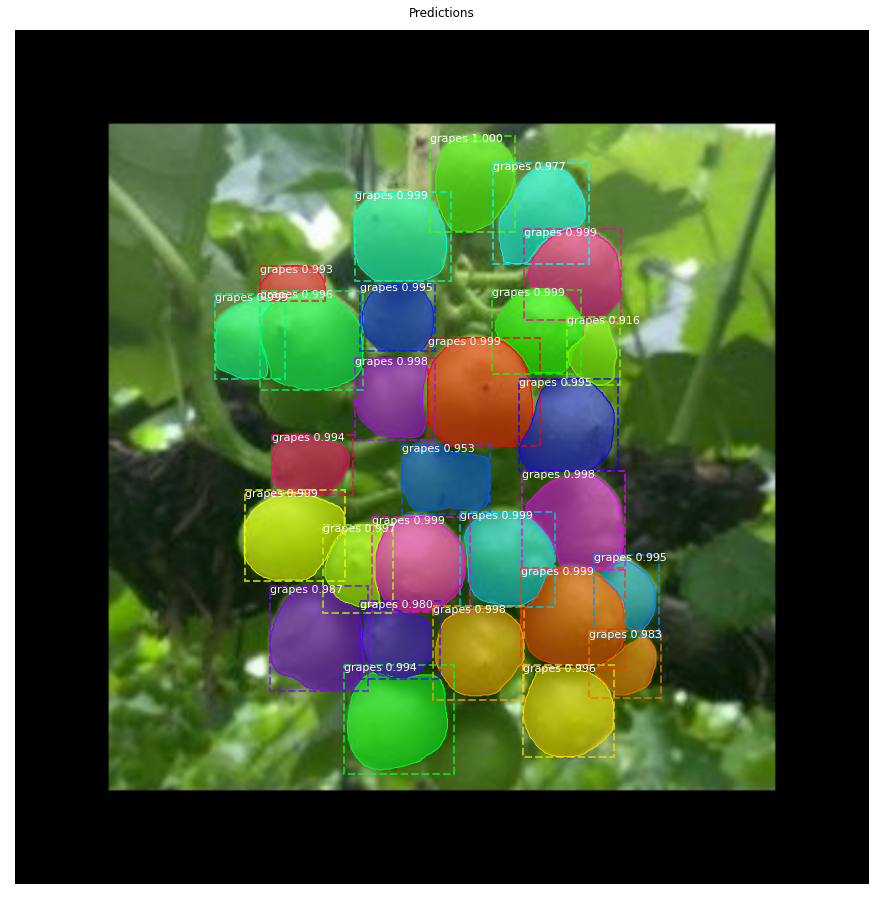

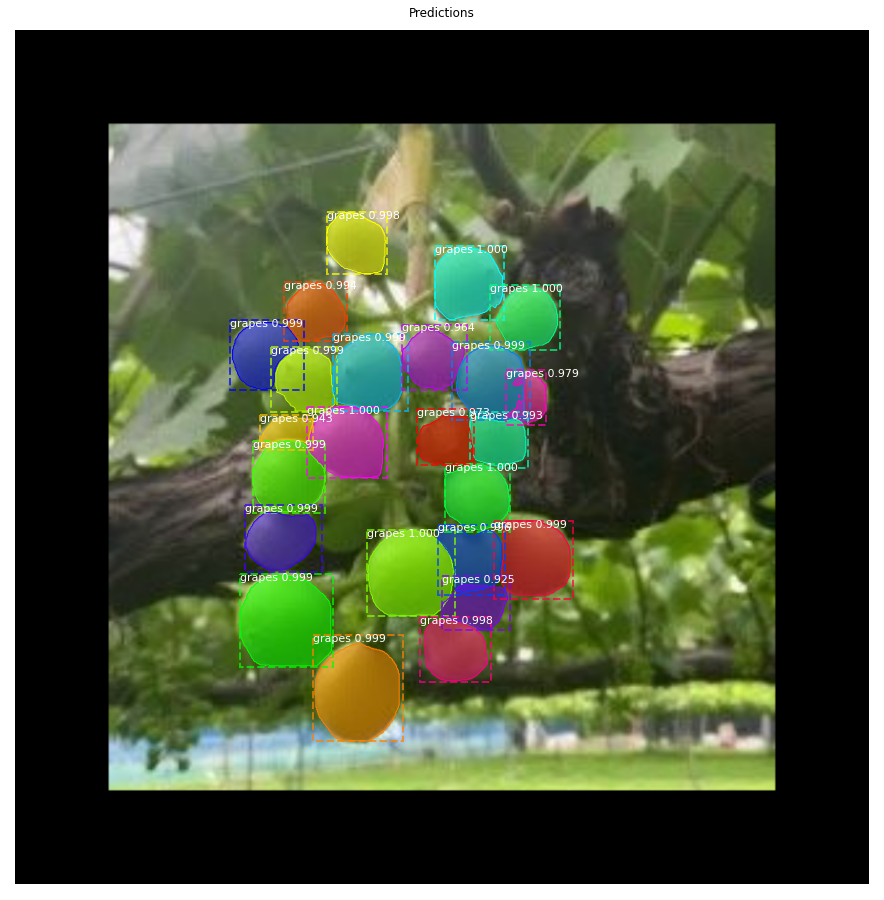

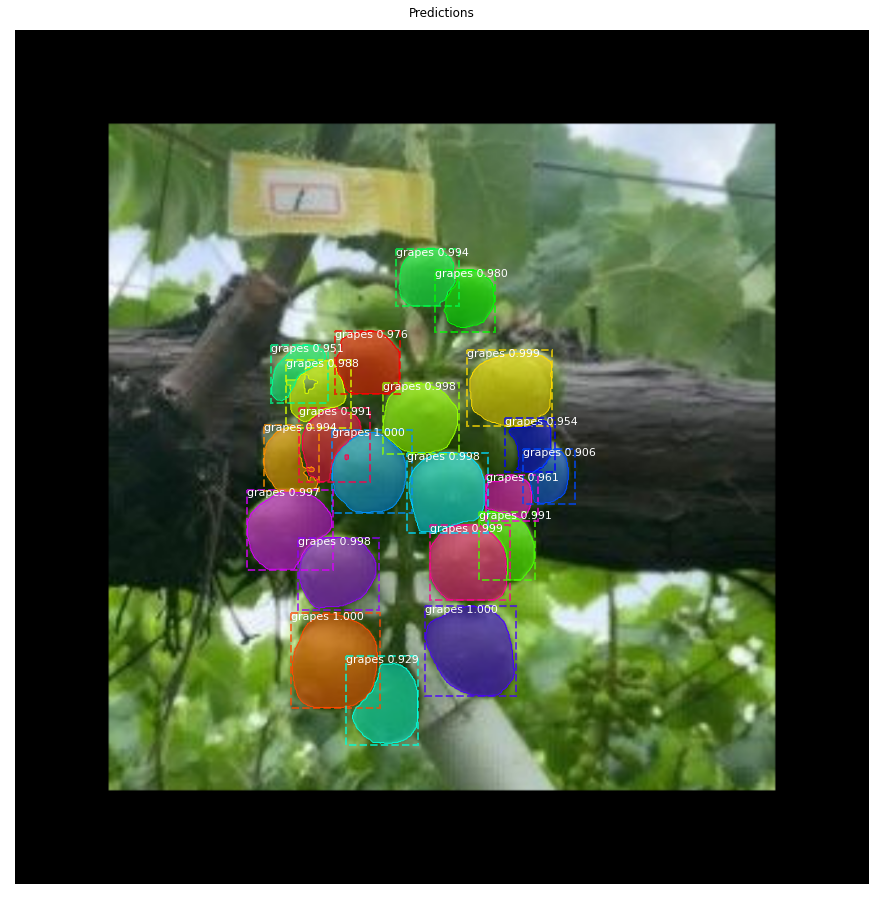

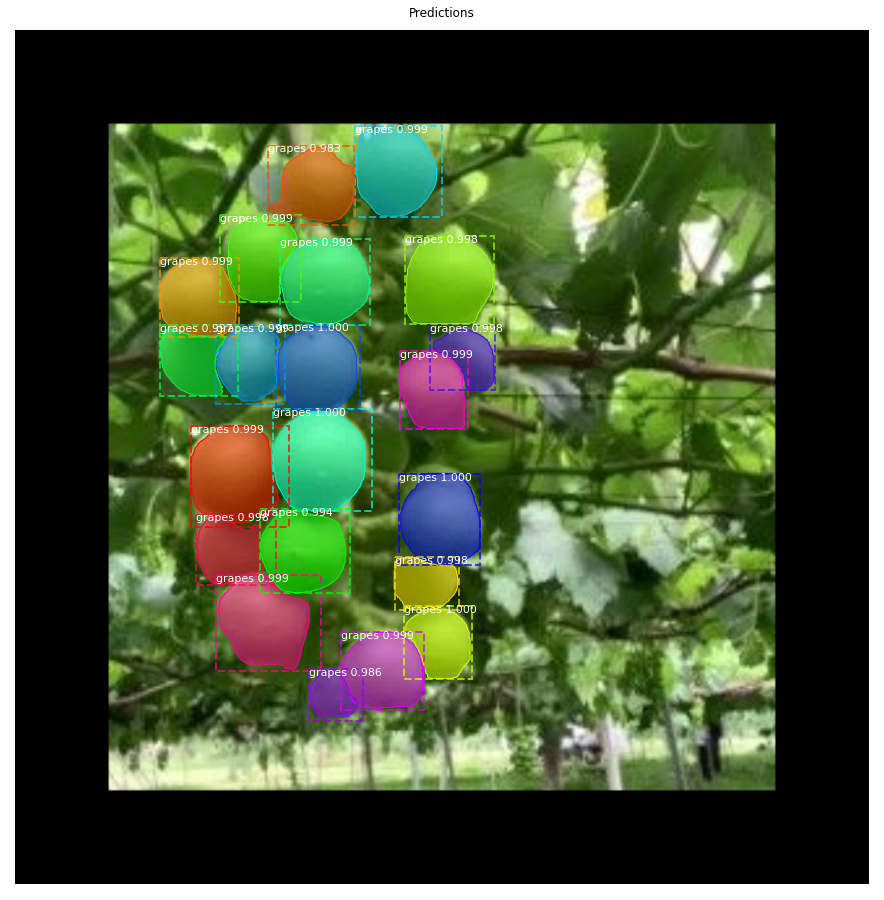

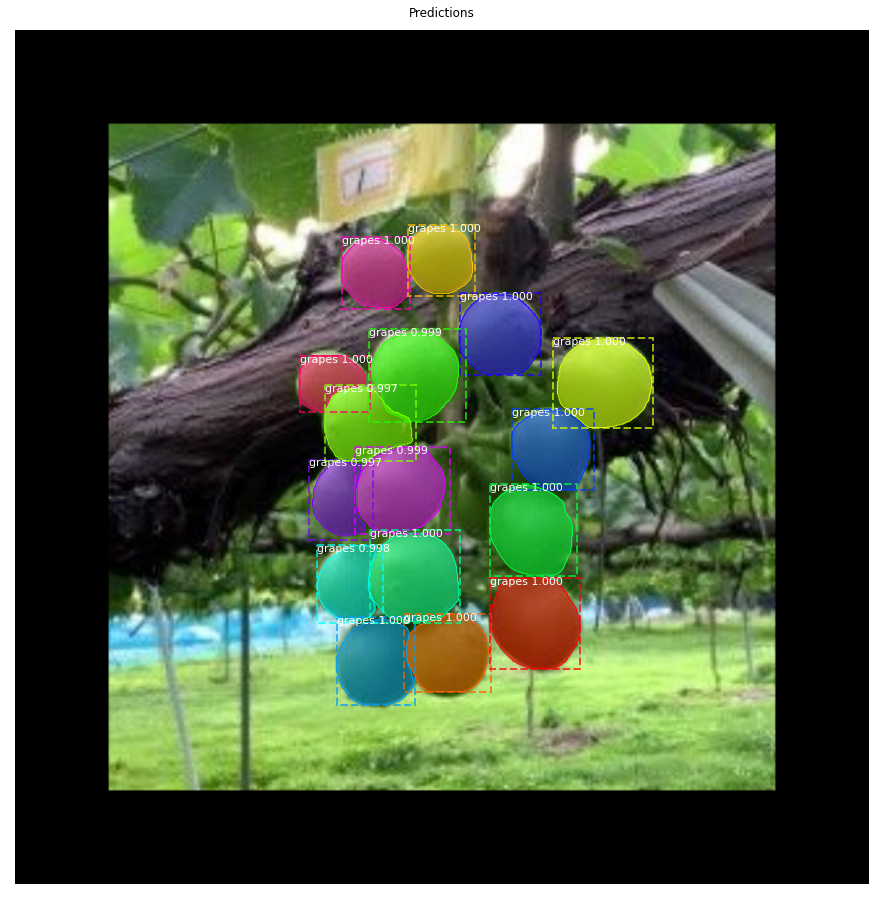

In [11]:
#image_id = random.choice(dataset.image_ids)
for image_id in dataset.image_ids:
  image, image_meta, gt_class_id, gt_bbox, gt_mask =\
      modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
  info = dataset.image_info[image_id]
  print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                         dataset.image_reference(image_id)))

  # 物体検出の実行
  results = model.detect([image], verbose=1)

  # 表示結果
  ax = get_ax(1)
  r = results[0]
  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                              dataset.class_names, r['scores'], ax=ax,
                              title="Predictions")
  log("gt_class_id", gt_class_id)
  log("gt_bbox", gt_bbox)
  log("gt_mask", gt_mask)

In [17]:
# 検証用データセットの読み込み
dataset = grapes.GrapesDataset()

# VOC-Style mAP @ IoU=0.5を算出する。
# 10枚の画像で動作します。精度を上げるために増やしてください。
image_ids = np.random.choice(dataset.image_ids, 5)
APs = []
for image_id in image_ids:
    # Load image
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config,
                               image_id, use_mini_mask=False)
    # Run object detection
    results =model.detect(image[np.newaxis], image_meta[np.newaxis], verbose=0)
    # Compute AP over 0.5
    r = results[0]
    ap, precisions_out, recalls_out, overlaps_out = utils.compute_ap(
        gt_bbox, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'])
    
    APs.append(ap)
    precisions.append(precisions_out)
    recalls.append(recalls_out)
    overlaps.append(overlaps_out)
    
    if verbose:
        info = dataset.image_info[image_id]
        meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
        print("{:3} {}   AP: {:.2f}".format(
            meta["image_id"][0], meta["original_image_shape"][0], ap))
        
return APs, precisions, recalls, overlaps
    
print("mAP: ", np.mean(APs))

ValueError: ignored